<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

### Импорт библиотек

In [ ]:
import os

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.transforms as tt

import torch
import torch.nn as nn
import cv2

from tqdm.notebook import tqdm

import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

from IPython.display import clear_output
from time import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_predict

In [ ]:
# Примонтируем свой диск, чтобы сохранять промежуточные результаты работы
from google.colab import drive as gog_drive
gog_drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# папки для сохранения весов модели, логов, промежуточных результатов работы
DATA_DIR = '/content/gdrive/MyDrive/DLS_MFTI/DLS_adv/W10_GAN/W10_hw_GAN/'
M_WEIGHTS = DATA_DIR + 'model_weights/'
M_LOGS = DATA_DIR + 'logs/'
FACES = DATA_DIR + 'faces/faces'

In [ ]:
# папки для сохранения весов модели, лоссов, оценок и изображений
os.makedirs(M_WEIGHTS, exist_ok=True)
os.makedirs(M_LOGS, exist_ok=True)
os.makedirs(FACES, exist_ok=True)

In [ ]:
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Mon Jun  7 17:09:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
# import gc
# model=None
# gc.collect()

11735

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

### Скачаем и разархивируем датасет

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%%time
# Скачаем архив с датасетом
downloaded = drive.CreateFile({'id':'1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9'})
downloaded.GetContentFile('faces_dataset_small.zip')

CPU times: user 5.53 s, sys: 37.6 s, total: 43.1 s
Wall time: 1min 35s


In [ ]:
%%time
#Разархивируем данные
!unzip -q /content/faces_dataset_small.zip -d faces

replace faces/faces_dataset_small/03836.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace faces/faces_dataset_small/04181.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: CPU times: user 259 ms, sys: 72 ms, total: 331 ms
Wall time: 45.6 s


In [ ]:
for address, dirs, files in os.walk('/content/faces'):
  print(address, dirs, len(files))

/content/faces ['__MACOSX', 'faces_dataset_small'] 0
/content/faces/__MACOSX ['faces_dataset_small'] 1
/content/faces/__MACOSX/faces_dataset_small [] 1
/content/faces/faces_dataset_small ['04000'] 3144
/content/faces/faces_dataset_small/04000 [] 1


In [ ]:
# Удалим лишнюю папку
import shutil
shutil.rmtree('/content/faces/__MACOSX/')
shutil.rmtree('/content/faces/faces_dataset_small/04000/')

На изображениях в текущем виде сеть обучения очень долго (2 минуты на эпоху). Конвертируем их, преобразуем и сохраним на диск

In [ ]:
%%time
from PIL import Image

image_size = 256

path = '/content/faces/faces_dataset_small/'

spam = 0
for _, _, files in os.walk(path):
  for fname in files:
    if fname.endswith(".png"):
      im = Image.open(os.path.join(path, fname))
      rgb_im = im.convert('RGB')
      rgb_im = rgb_im.resize((image_size, image_size))
      rgb_im.save(os.path.join(FACES, fname[:-4]+'.jpg'))
      spam += 1

print(f'{spam} images converted to .jpg and resized to {(image_size, image_size)}')

3143 images converted to .jpg and resized to (256, 256)
CPU times: user 2min 53s, sys: 11.2 s, total: 3min 5s
Wall time: 3min 22s


### Создадим Dataloader и переместим на cuda

Будем использовать для обучения изображения из папки /content/faces/faces_dataset_small

In [ ]:
FACES_DIR = FACES[:-5]

In [ ]:
def get_dataloader(batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader

  # train_ds = ImageFolder(
  #       FACES_DIR, 
  #       transform=tt.Compose(
  #           [
  #           tt.Resize(image_size+20),
  #           tt.CenterCrop(image_size),
  #           tt.ToTensor()
  #           ]
  #         )
  #     )
    
  train_ds = ImageFolder(FACES_DIR, transform = tt.ToTensor())  
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

  return train_dl

In [ ]:
# Создадим dataloader
image_size = 256
batch_size = 128

train_dl = get_dataloader(batch_size)
print('Размера Dataloader', len(train_dl.dataset))

Размера Dataloader 3143


In [ ]:
# Функции для перемещения на cuda

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, DEVICE)

### Напишем функцию для отрисовки изображений

In [ ]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach().cpu()[:nmax], nrow=8).permute(1, 2, 0))

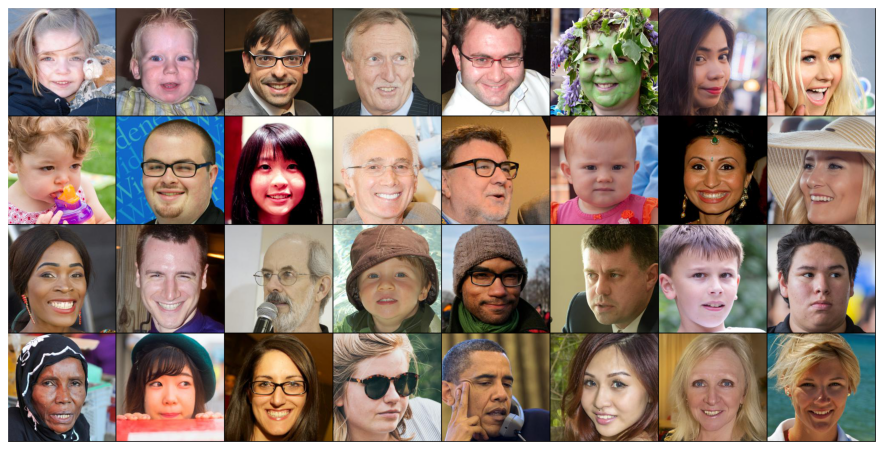

In [ ]:
x, _ = next(iter(train_dl))
show_images(x)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

### Дискриминатор

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 256 x 256

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    # nn.MaxPool2d(2),
    # # out: 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.MaxPool2d(2),
    # out: 64 x 32 x 32

    # nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(256),
    # nn.LeakyReLU(0.2, inplace=True),
    # # out: 256 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    )

In [ ]:
# with torch.no_grad():
#   input = torch.randn((128,3,256,256))
#   otput = discriminator(input)
# otput.shape

torch.Size([128, 1])

### Генератор

In [ ]:
latent_size = 512 # choose latent size

generator = nn.Sequential(
        # in: latent_size x 1 x 1    
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    # out: 512 x 8 x 8

    # nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=0, bias=False),
    # nn.BatchNorm2d(512),
    # nn.ReLU(True),
    # # out: 512 x 16 x 16

    nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 32 x 32

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 64 x 64

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Sigmoid()
    # out: 3 x 256 x 256
)

In [ ]:
# with torch.no_grad():
#   input = torch.randn((128,512,1,1)).to(DEVICE)
#   otput = generator.to(DEVICE)(input)
# otput.shape

torch.Size([128, 3, 256, 256])

### Сохранение сгенерированных изображений

In [ ]:
fixed_latent = torch.randn(32, latent_size, 1, 1, device=DEVICE)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    if os.path.exists(os.path.join(M_LOGS, fake_fname)):
      os.remove(os.path.join(M_LOGS, fake_fname))

    save_image(fake_images, os.path.join(M_LOGS, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.detach().cpu(), nrow=8).permute(1, 2, 0))

### Функция обучения модели

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 1e-3

model = {
    "discriminator": discriminator.to(DEVICE),
    "generator": generator.to(DEVICE)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
# Функция для отрисовки графиков и изображений (каждые 10 эпох)
def plot_gen_metrics(fake_images, dict_metrics, epoch):
    images = np.clip(fake_images[:8].permute(0, 2, 3, 1).numpy(), 0, 1)
    plt.figure(figsize=(15, 9))
    
    for i in range(8):
      plt.subplot(3, 8, i+1)
      plt.axis("off")
      plt.imshow(images[i])

    plt.subplot(3,1,2)
    plt.plot(dict_metrics['losses_d'], '-')
    plt.plot(dict_metrics['losses_g'], '-')
    #plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses')
    
    plt.subplot(3,1,3)
    plt.plot(dict_metrics['real_scores'], '-')
    plt.plot(dict_metrics['fake_scores'], '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['Real', 'Fake'])
    plt.title('Scores')
    
    plt.suptitle(f"epoch: {epoch + 1} - loss_g: {dict_metrics['losses_g'][-1]:.4f} - loss_d: {dict_metrics['losses_d'][-1]:.4f}",
                      fontsize=16)
    plt.tight_layout()          
    plt.show();

In [ ]:
# input = torch.randn(128, 3, 256, 256)
# dict_m = {
#               'losses_g': [i for i in range(9)],
#               'losses_d': [2*i for i in range(9)],
#               'real_scores': [i/2 for i in range(9)],
#               'fake_scores': [3*i/2 + 1 for i in range(9)]
#           }
# plot_gen_metrics(input, dict_m, 9)

In [ ]:
def fit(model, criterion, epochs, lr):
  
    since = time()
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    # scheduler = {
    #     "discriminator": lr_scheduler.StepLR(optimizer["discriminator"], step_size=20, gamma=0.8),
    #     "generator": lr_scheduler.StepLR(optimizer["generator"], step_size=20, gamma=0.8)
    # }
    
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            smooth = torch.rand(real_images.size(0), 1, device=DEVICE) / 20
            real_targets -= smooth
            
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=DEVICE)
            smooth = torch.rand(fake_images.size(0), 1, device=DEVICE) / 20
            fake_targets += smooth

            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            # scheduler["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=DEVICE)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            # scheduler["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, time: {} min".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1], (time()-since)//60))
            
        # Save model, images, losses, scores
        dict_metrics = {
              'losses_g': losses_g,
              'losses_d': losses_d,
              'real_scores': real_scores,
              'fake_scores': fake_scores
        }       
        
        if (epoch + 1) % 20 == 0:         
          save_samples(epoch+1, fixed_latent, show=False)
          torch.save(model['discriminator'].state_dict(), os.path.join(M_WEIGHTS, 'm_disc_epoch_' + str(epoch+1) + '.pth'))
          torch.save(model['generator'].state_dict(), os.path.join(M_WEIGHTS, 'm_gen_epoch_' + str(epoch+1) + '.pth'))
          
          with open(os.path.join(M_LOGS, 'metrics_table_' + str(epoch+1) + '_epoch.pickle'), 'wb') as f:
            pickle.dump(dict_metrics, f)

          # Visualize tools---------------------------------
        if (epoch + 1) % 5 == 0:
            clear_output(wait=True)
            plot_gen_metrics(fake_images.detach().cpu(), dict_metrics, epoch)
          
    # final ----------------------------------------------------------
    print("Training is done! Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, time: {} min".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], 
            real_scores[-1], fake_scores[-1], 
            (time()-since)//60
            )
    )

    return model
  

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

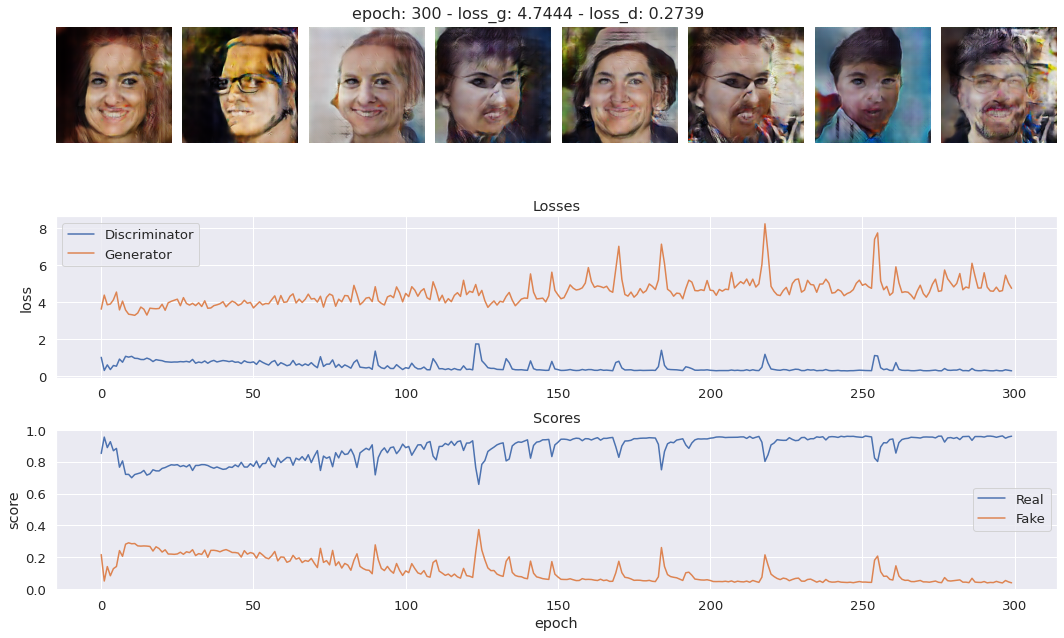

Training is done! Epoch [300/300], loss_g: 4.7444, loss_d: 0.2739, real_score: 0.9605, fake_score: 0.0382, time: 147.0 min


In [ ]:
model = fit(model, criterion, 300, lr)

In [ ]:
def show_gen(num_epoch):
  if (num_epoch % 20 != 0) or (num_epoch < 0) or (num_epoch > 300):
    print('Количество эпох должно быть не меньше 20, не больше 300 и кратно 20')
  
  else:
    fake_fname = 'generated-images-{0:0=4d}.png'.format(num_epoch)
    generated_img = cv2.imread(os.path.join(M_LOGS, fake_fname))
    generated_img = generated_img[:, :, [2, 1, 0]]

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(generated_img)
    plt.show()

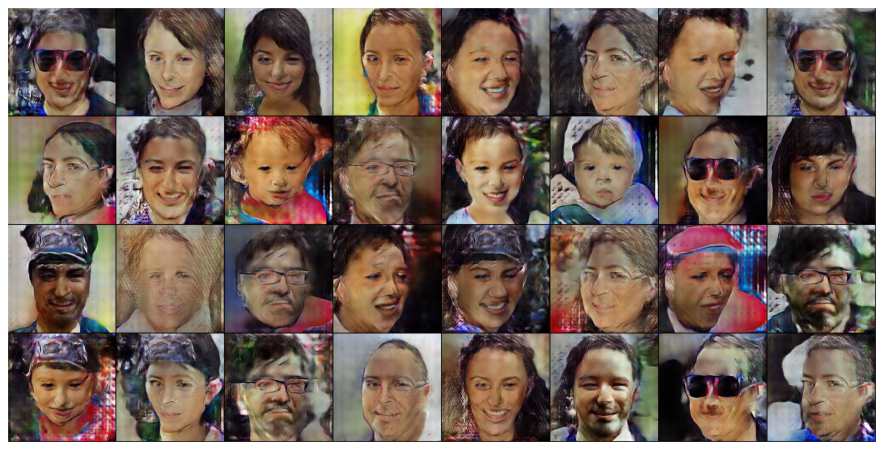

In [ ]:
show_gen(260)

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
# загрузим веса модели (на 260 эпохе)
gen = generator.to(DEVICE)
gen.load_state_dict(torch.load(os.path.join(M_WEIGHTS, 'm_gen_epoch_260.pth')))

<All keys matched successfully>

In [ ]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
fake_images = gen(fixed_latent)

In [ ]:
def show_gen_images(images):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach().cpu(), nrow=8).permute(1, 2, 0))

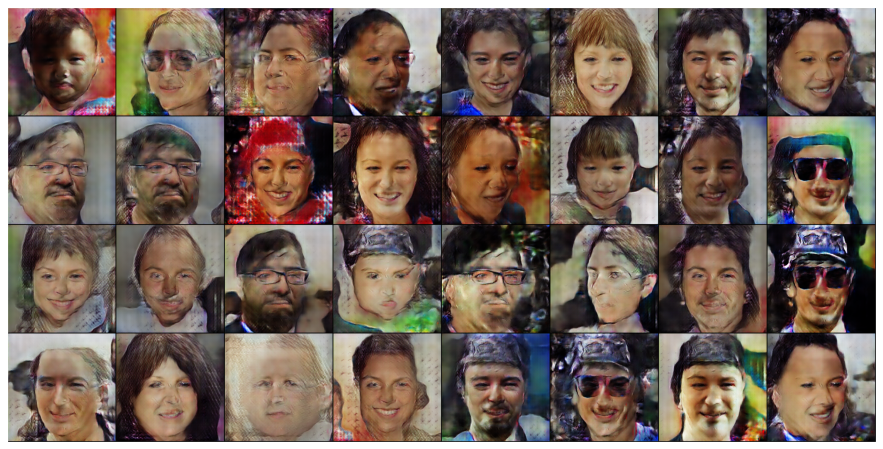

In [ ]:
show_gen_images(fake_images)

Как вам качество получившихся изображений?

Изображения содержат некоторые паттерны лиц людей. Лучше всего получились глаза. В целом, качество очень низкое.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
%%time
# Получим векторы всех лиц из dataloader
real_images = torch.Tensor().to(DEVICE)

for images, _ in train_dl:
  real_images = torch.cat((real_images, images.view(images.size(0),-1)), dim=0)

# targets = torch.ones((real_images.size(0), 1), device=DEVICE)
# real_images = torch.cat((real_images, targets), dim=1).cpu().detach().numpy()

real_images = real_images.detach().cpu()

CPU times: user 3.19 s, sys: 2.04 s, total: 5.22 s
Wall time: 11min 57s


In [ ]:
# Размер получившегося тензора
real_images.shape

torch.Size([3072, 196608])

In [ ]:
# Запишем векторы в словарь
with open(os.path.join(M_LOGS, 'real_images.pickle'), 'wb') as f:
  pickle.dump(real_images, f)

Файл real_images.pickle Занимает 2 Гб памяти. Будем выполнять задания не на всем датасете на 1000 реальных и 1000 фэйковых изображений

In [ ]:
%%time
# Получим столько же картинок, сгенерированных генератором
latent = torch.randn(1000, latent_size, 1, 1, device=DEVICE)

with torch.no_grad():
  fake_images = gen(latent)

# targets = torch.zeros((fake_images.size(0), 1), device=DEVICE)
# fake_images = torch.cat((fake_images, targets), dim=1).cpu().detach().numpy()

fake_images = fake_images.view(fake_images.size(0),-1).detach().cpu()

CPU times: user 1.35 s, sys: 305 ms, total: 1.66 s
Wall time: 1.65 s


In [ ]:
# Размер получившегося тензора
fake_images.shape

torch.Size([1000, 196608])

In [ ]:
# Запишем векторы в словарь
with open(os.path.join(M_LOGS, 'fake_images.pickle'), 'wb') as f:
  pickle.dump(fake_images, f)

In [ ]:
%%time
# Загрузим тензоры реальных и фэйковых изображений
with open(os.path.join(M_LOGS, 'real_images.pickle'), 'rb') as f:
        real_images = pickle.load(f)

with open(os.path.join(M_LOGS, 'fake_images.pickle'), 'rb') as f:
        fake_images = pickle.load(f)

CPU times: user 2.55 s, sys: 6.92 s, total: 9.47 s
Wall time: 39.4 s


In [ ]:
# Для подсчета accuracy склеим изображения и передем в numpy
real_images = real_images[:1000, :]
all_images = torch.cat((real_images, fake_images), dim=0).numpy()

In [ ]:
labels = np.zeros(2000)
labels[1000:] = 1

Изображения имеют слишком большой размер, и для выполнения предложенного варианта оценки с помощью LeaveOneOut() и KNeighborsClassifier(n_neighbors=1) не хватает оперативной памяти. Поскольку поиск ближайшего соседа осуществляется по расчету расстояния между векторами, напишем цикл по поиску ближайшего соседа с помощью эвклидовой нормы.

In [ ]:
N = len(all_images)
ndist = [None for _ in range(N)]
res = 0

for i in tqdm(range(N-1)): 

  nearest = None  

  for j in range(i + 1, N):
    cur_dist = np.linalg.norm(all_images[i] - all_images[j])
    
    if (ndist[i] is None) or (ndist[i] > cur_dist):
      ndist[i] = cur_dist
      ndist[j] = cur_dist
      nearest = j
        
  if (i < (N / 2) and nearest < (N / 2)) or (i >= (N / 2) and nearest >= (N / 2)):
    res += 1

In [ ]:
N = len(all_images)
res = 0

n_id = [None for _ in range(N)]
n_dist = [None for _ in range(N)]

for i in tqdm(range(N)):
  for j in range(i + 1, N):
    cur_dist = np.linalg.norm(all_images[i] - all_images[j])
    if (n_id[i] is None) or (cur_dist < n_dist[i]):
      n_dist[i] = cur_dist
      n_id[i] = j
    if (n_id[j] is None) or (n_dist[j] > cur_dist):
      n_dist[j] = cur_dist
      n_id[j] = i
  if (i < (N / 2) and n_id[i] < (N / 2)) or (i >= (N / 2) and n_id[i] >= (N / 2)):
    res += 1

In [ ]:
N = len(all_images)
ndist = np.zeros([N, N])

for i in range(N):
  for j in range(N):
    ndist[i,j] = np.linalg.norm(all_images[i] - all_images[j])



In [ ]:
a = np.random.randint(0, 20, size = (3, 5))
a

In [ ]:
np.argmin(a)

In [ ]:
accuracy = res / N
print(f'Accuracy on 1000 real images and 1000 fake images = {accuracy}')

Accuracy on 1000 real images and 1000 fake images = 0.7275


In [ ]:
# %%time
# # посчитаем accuracy
# loo = LeaveOneOut()
# classif = KNeighborsClassifier(n_neighbors=1)

# preds = cross_val_predict(classif, all_images, labels, cv=loo, n_jobs=-1)

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Идеальным результатом было бы получить accuracy = 0.5, что означало бы, что невозможно отличить сгенерированные изображения от настоящих.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
# Загрузим тензоры реальных и фэйковых изображений
with open(os.path.join(M_LOGS, 'real_images.pickle'), 'rb') as f:
        real_images = pickle.load(f)

with open(os.path.join(M_LOGS, 'fake_images.pickle'), 'rb') as f:
        fake_images = pickle.load(f)

In [ ]:
# Для TSNE слеим их и переведем в numpy
real_images = real_images[:1000, :]
all_images = torch.cat((real_images, fake_images), dim=0).numpy()
all_images.shape

(2000, 196608)

In [ ]:
%%time
# Применим PCA для понижение размерности (иначе для TSNE не хватает оперативной памяти)
pca_images = PCA(n_components=2000, random_state=1).fit_transform(all_images)

CPU times: user 7min 14s, sys: 40.9 s, total: 7min 55s
Wall time: 4min 7s


In [ ]:
# Запишем сжатые изображения в словарь
with open(os.path.join(M_LOGS, 'pca_images.pickle'), 'wb') as f:
            pickle.dump(pca_images, f)

In [ ]:
%%time
# Уменьшим размерность сжатых PCA изображений
all_tsne = TSNE(n_components=2, random_state=1, n_jobs=-1).fit_transform(pca_images)
all_tsne.shape

CPU times: user 36.6 s, sys: 324 ms, total: 37 s
Wall time: 27 s


In [ ]:
# Запишем латентные представления
with open(os.path.join(M_LOGS, 'all_tsne.pickle'), 'wb') as f:
    pickle.dump(all_tsne, f)

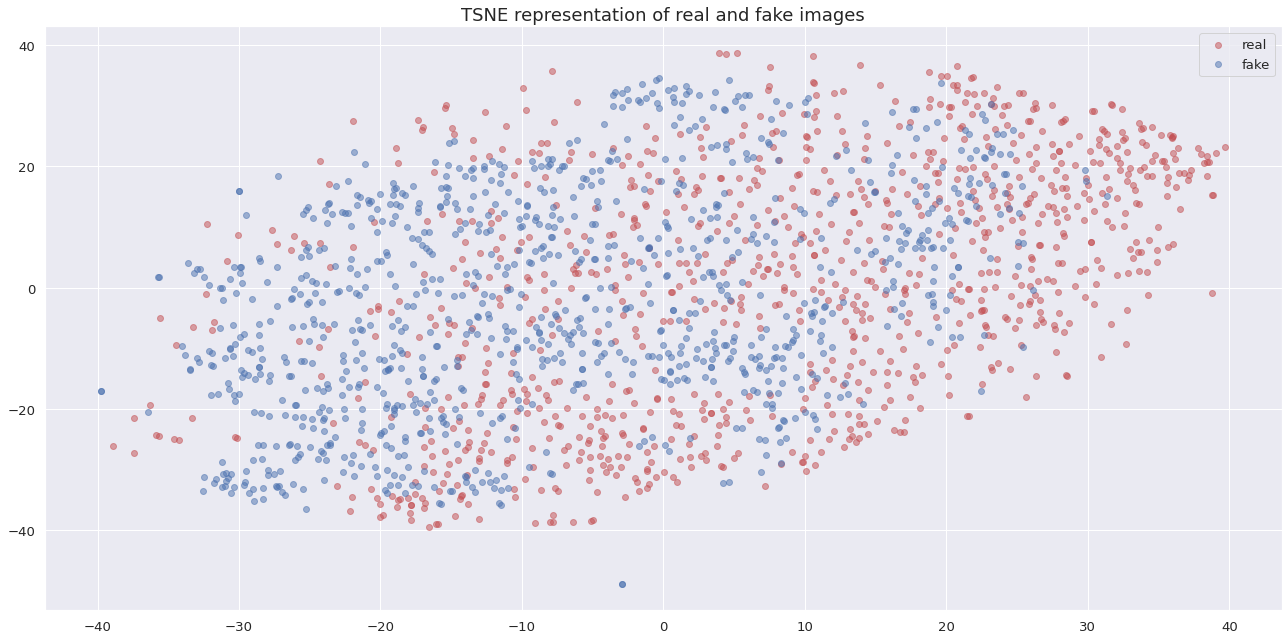

In [ ]:
# Отрисуем точки, соответствующие реальным и сгенерированным изображениям
plt.figure(figsize=(18, 9))

plt.scatter(all_tsne[:1000, 0], 
            all_tsne[:1000, 1], 
            c='r', 
            alpha=0.5, 
            label='real'
            )
plt.scatter(all_tsne[1000:, 0], 
            all_tsne[1000:, 1], 
            c='b', 
            alpha=0.5, 
            label='fake'
            )      

plt.title('TSNE representation of real and fake images', fontsize=18)  
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Прокомментируйте получившийся результат:

К сожалению, без применения PCA перед TSNE, обойтись не получилось (не хватает оперативной памяти, чтобы сжать $3*256*256$ в $2$).
Но если судить по текущему результату, то отображение реальных изображений и сгенерированных довольно сильно перемешаны и линейно неразделимы. По результатам обучения генератора, я ожидала, что отображения будут довольно легко отделимы.